<a href="https://colab.research.google.com/github/ichiP245/TP-Anal-tica-Descriptiva/blob/main/notebooks/TP_Descriptiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis del mercado inmobiliario - Lianjia

### Descripcion sobre las variables

- url: the url which fetches the data

- id: the id of transaction

- Lng: and Lat coordinates, using the BD09 protocol.

- Cid: community id

- tradeTime: the time of transaction

- DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market

- followers: the number of people follow the transaction.

- totalPrice: the total price

- price: the average price by square

- square: the square of house

- livingRoom: the number of living room

- drawingRoom: the number of drawing room

- kitchen: the number of kitchen

- bathroom the number of bathroom

- floor: the height of the house. This column is in Chinese characters (they will be replaced by English ones in the next version to be available).

- buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).

- constructionTime: the time of construction

- renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )

- buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).

- ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average.

- elevator have ( 1 ) or not have elevator( 0 )

- fiveYearsProperty: if the owner have the property for less than 5 years

- subway

- district

- communityAverage

### Hipotesis:
- Hipótesis 1: Los departamentos de menos ambientes presentan un precio por m² más alto que los de mayor tamaño.
- Hipótesis 2: La superficie es el factor principal del precio.
- Hipótesis 3: La condición de renovación tiene un gran impacto en el precio, pero no del precio por m².
- Hipótesis 4: La cantidad de seguidores tiene una alta correlacion con el precio por m².
- Hipótesis 5: El impacto en el precio por m² de la cercania al metro es más alta en departamentos chicos que grandes.
- Hipotesis 6: La ubicación del departamento está asociado con el precio total y la cantidad de habitaciones.
- Hipotesis 7: hay determinados tipos de construcciones/edificios que solo se relacionan con ciertos rangos de construcción de los edificios

#Importacion de librerias

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import json

#Ingesta de datos

In [107]:
# Leemos el dataset de propiedades inmobiliarias
df = pd.read_csv('new.csv',encoding='GBK')

/tmp/ipython-input-25070946.py:2: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('new.csv',encoding='GBK')


Cargamos dataset de subtes

In [37]:
url = 'https://raw.githubusercontent.com/ichiP245/TP-Anal-tica-Descriptiva/refs/heads/main/data/subway.txt'

In [38]:
file = open('/content/subway.txt','r',encoding='utf-8')
file = file.read()
file = json.loads(file)
# file['l'][0]

In [39]:
def get_lines_stations_info(url_text):
    #解析text数据，将其变成字典数据 -> #Analizar datos de texto y convertirlos en datos de diccionario
    data = pd.read_json(url, encoding='utf-8')
    beijing_subway = data['l'].to_dict()
    pass

    # 遍历json数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    # ->
    # Recorrer los datos JSON y construir una estructura de datos de ubicación
    # Un diccionario con toda la información de la ruta: clave: nombre de la ruta; valor: lista de nombres de estaciones
    lines_info = {}

    for line in range(len(beijing_subway)):
        line_key = beijing_subway[line]['ln']
        line_value = []
        for station in range(len(beijing_subway[line]['st'])):
            line_value.append(beijing_subway[line]['st'][station]['n'])
        lines_info[line_key] = line_value

    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    # Un diccionario de toda la información del sitio: clave: nombre del sitio; valor: coordenadas del sitio (x, y)
    stations_info = {}

    for line in range(len(beijing_subway)):
        for station in range(len(beijing_subway[line]['st'])):
            station_key = beijing_subway[line]['st'][station]['n']
            station_value = eval(beijing_subway[line]['st'][station]['sl'])
            stations_info[station_key] = station_value

    return lines_info,stations_info

lines_info, stations_info = get_lines_stations_info(url)

In [40]:
# Vemos las dos primeras estaciones con sus ubicaciones
list(stations_info.items())[:2]

[('金安桥', (116.163167, 39.92362)), ('四道桥', (116.13401, 39.91603))]

In [54]:
len(stations_info)

340

In [60]:
datos_df = {'Estacion': list(), 'Latitud': list(), 'Longitud': list()}
for estacion in stations_info:
  datos_df['Estacion'] = datos_df['Estacion'] + [estacion]
  datos_df['Latitud'] = datos_df['Latitud'] + [stations_info[estacion][0]]
  datos_df['Longitud'] = datos_df['Longitud'] + [stations_info[estacion][1]]
df_subte = pd.DataFrame(datos_df)

A partir de ahora hacemos el analisis sobre el dataset de propiedades inmobiliarias

### Formato del dataset

In [62]:
# Primeras filas
df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [63]:
# Filas y columnas
df.shape

(318851, 26)

In [64]:
# Columnas y tipos de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

### Estadisticos principales

In [73]:
# Tenemos un problema. Hay columnas que no detecto como numericas
# -> vamos a tener que limpiarlas y despues volver a realizar el analisis de estadisticos

# Ademas, van a haber variables que son categoricas y han sido pasadas a numericas, que no tiene sentido hacerles un analisis de estadisticos
df.select_dtypes('number').columns

Index(['Lng', 'Lat', 'Cid', 'DOM', 'followers', 'totalPrice', 'price',
       'square', 'kitchen', 'buildingType', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'district', 'communityAverage'],
      dtype='object')

In [74]:
lista_cols = ['Lat', 'Cid', 'DOM', 'followers', 'totalPrice', 'price','square', 'kitchen', 'communityAverage']
df[lista_cols].describe()

,Lat,Cid,DOM,followers,totalPrice,price,square,kitchen,communityAverage
count,318851.000000,3.188510e+05,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,318388.000000
mean,39.949591,1.129113e+12,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,63682.446305
std,0.091983,2.363447e+12,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,22329.215447
min,39.627030,1.111027e+12,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,10847.000000
25%,39.893200,1.111027e+12,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,46339.000000
50%,39.934527,1.111027e+12,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,59015.000000
75%,40.003018,1.111027e+12,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,75950.000000
max,40.252758,1.114620e+15,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,183109.000000


### Analisis faltantes

Previo a analizar los faltantes, vamos a analizar variable por variable a ver si aparecen posibles nulos

In [75]:
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
[101084782030 101086012217 101086041636 ... 'BJYZ92324217' 'BJYZ92333313'
 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
['2016-08-09' '2016-07-28' '2016-12-11' ... '2012-01-28' '2011-01-30'
 '2009-01-11']

DOM
[1.464e+03 9.030e+02 1.271e+03 9.650e+02 9.270e+02 8.610e+02 8.510e+02
 9.040e+02 8.730e+02 8.650e+02 8.270e+02 7.730e+02 7.930e+02 7.840e+02
 7.060e+02 8.000e+02 7.390e+02 7.900e+02 6.910e+02 7.470e+02 6.900e+02
 6.970e+02 6.8

Como se puede ver aparecen muchos caracteres raros, vamos a analizar las filas que los contienen y los que no

In [77]:
# Vemos las filas que tienen valores extraños o incoherentes en la columna 'bathRoom'
df[df['bathRoom'].isin([2006, 2003, 1990, 2000, 1996, 2005, 2011, '未知', 1994, 2004, '2003'])]

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
92235,https://bj.lianjia.com/chengjiao/BJ0000615040....,BJ0000615040,116.117724,39.941152,1111052110644,2010-02-21,1.0,0,198.0,15729,125.89,#NAME?,中 14,3,2006,钢混结构,0.500,1,0,0,0.0,NaN,NaN,NaN,12,39492.0
92251,https://bj.lianjia.com/chengjiao/BJ0000615084....,BJ0000615084,116.121964,39.939762,1111027375862,2010-03-07,1.0,0,136.0,14601,93.15,#NAME?,中 15,4,2003,钢混结构,0.333,1,0,0,0.0,NaN,NaN,NaN,12,37588.0
92267,https://bj.lianjia.com/chengjiao/BJ0000615132....,BJ0000615132,116.118409,39.937888,1111043529456,2010-03-22,1.0,0,127.0,14613,86.91,#NAME?,中 16,4,2006,钢混结构,0.333,1,0,0,0.0,NaN,NaN,NaN,12,38753.0
92270,https://bj.lianjia.com/chengjiao/BJ0000615138....,BJ0000615138,116.111318,39.949921,1111027377794,2010-03-23,1.0,0,115.0,14240,80.76,#NAME?,中 6,4,2003,混合结构,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36923.0
92297,https://bj.lianjia.com/chengjiao/BJ0000615208....,BJ0000615208,116.117724,39.941152,1111052110644,2010-04-10,1.0,0,100.0,17242,58.00,#NAME?,高 14,3,2006,钢混结构,0.125,1,0,0,0.0,NaN,NaN,NaN,12,39492.0
92299,https://bj.lianjia.com/chengjiao/BJ0000615220....,BJ0000615220,116.111318,39.949921,1111027377794,2010-04-13,1.0,0,205.0,13021,157.44,#NAME?,顶 6,4,2006,混合结构,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36923.0
92300,https://bj.lianjia.com/chengjiao/BJ0000615222....,BJ0000615222,116.118409,39.937888,1111043529456,2010-04-13,1.0,0,146.5,15985,91.65,#NAME?,中 16,4,2006,钢混结构,0.500,1,0,0,0.0,NaN,NaN,NaN,12,38753.0
92304,https://bj.lianjia.com/chengjiao/BJ0000615229....,BJ0000615229,116.117019,39.933860,1111052073923,2010-04-17,1.0,0,90.0,14288,62.99,#NAME?,中 6,4,1990,混合结构,0.333,0,0,0,0.0,NaN,NaN,NaN,12,39381.0
92340,https://bj.lianjia.com/chengjiao/BJ0000615401....,BJ0000615401,116.122354,39.937384,1111027376723,2010-09-09,1.0,0,130.0,17640,73.70,#NAME?,低 6,4,2000,混合结构,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36358.0
92349,https://bj.lianjia.com/chengjiao/BJ0000615438....,BJ0000615438,116.117724,39.941152,1111052110644,2010-09-29,1.0,0,109.5,17484,62.63,#NAME?,中 14,3,2006,钢混结构,0.125,1,0,0,0.0,NaN,NaN,NaN,12,39492.0


In [108]:
# Nos quedamos con los registros que NO tienen valores extraños en 'bathRoom' y vemos que las
# columnas que cuando antes hicimos .unique() tenian valores raros, ahora desaparecieron
df1 = df.loc[~df['bathRoom'].isin([2006, 2003, 1990, 2000, 1996, 2005, 2011, '未知', 1994, 2004, '2003',])]
print(df1['livingRoom'].unique())
print(df1['drawingRoom'].unique())
print(df1['buildingType'].unique())
print(df1['floor'].unique())

[2 3 1 4 5 6 9 0 7 8 '1' '4' '3' '2' '5' '7' '9' '6' '0' '8']
[1 2 0 4 3 5 '0' '1' '2' '3' '4' '5']
[ 1.  4.  3. nan  2.]
['高 26' '高 22' '中 4' '底 21' '中 6' '中 8' '高 6' '高 10' '中 23' '底 11' '底 3'
 '高 24' '低 23' '中 19' '高 18' '低 25' '中 12' '中 14' '中 30' '中 27' '中 5'
 '低 18' '底 28' '中 11' '低 9' '顶 7' '顶 27' '低 6' '中 17' '顶 6' '中 24' '中 15'
 '底 5' '中 29' '顶 19' '顶 5' '中 9' '低 22' '顶 18' '低 16' '高 13' '高 9' '高 17'
 '底 6' '中 28' '低 26' '底 15' '高 16' '底 2' '低 7' '中 13' '低 33' '底 14' '高 15'
 '底 4' '顶 11' '中 32' '顶 16' '底 18' '顶 17' '低 14' '低 10' '底 20' '高 12'
 '低 31' '低 30' '低 19' '低 12' '中 10' '中 16' '顶 20' '底 19' '中 31' '低 13'
 '底 10' '高 25' '中 21' '中 20' '高 20' '低 21' '低 24' '顶 4' '高 21' '高 7'
 '中 22' '底 1' '中 7' '底 8' '顶 15' '中 18' '高 28' '顶 14' '顶 13' '低 20' '底 26'
 '低 17' '顶 24' '底 23' '顶 3' '顶 21' '底 24' '高 30' '高 11' '底 25' '高 27'
 '底 9' '低 11' '低 28' '低 15' '顶 26' '低 34' '顶 12' '中 25' '高 8' '底 17'
 '高 32' '高 19' '底 7' '顶 28' '顶 9' '高 31' '中 26' '顶 2' '顶 8' '底 32' '中 42'
 '底 30' '低 32'

Se pudo ver que todas las filas que tenian caracteres raros o sin sentido, los tenian en muchas columnas, como 'bathRoom' siendo un año, 'livingRoom' siendo #NAME, drawingRoom con simbolos raros, 'floor' siendo letras y 'buildingType' no siendo un entero como corresponde. En cambio cuando vemos el dataset sin estas filas, todos los valores quedan con el mismo formato y sin caracteres raros a excepcion de 'floor' que la investigaremos luego.

Por lo que, vamos a truncar todas las filas con esos caracteres raros.

In [109]:
df = df1

Hacemos el mismo analisis pero sin las filas eliminadas

In [80]:
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
[101084782030 101086012217 101086041636 ... 'BJYZ92324217' 'BJYZ92333313'
 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
['2016-08-09' '2016-07-28' '2016-12-11' ... '2012-01-28' '2011-01-30'
 '2009-01-11']

DOM
[1.464e+03 9.030e+02 1.271e+03 9.650e+02 9.270e+02 8.610e+02 8.510e+02
 9.040e+02 8.730e+02 8.650e+02 8.270e+02 7.730e+02 7.930e+02 7.840e+02
 7.060e+02 8.000e+02 7.390e+02 7.900e+02 6.910e+02 7.470e+02 6.900e+02
 6.970e+02 6.8

Se puede ver que hay variables que tienen distintos tipos de datos, en DOM y en buildingType aparece el valor nan y en constructionTime aparece '未知' que al traducirlo significa 'desconocido'.

In [82]:
display(df[['DOM','buildingType']].isna().sum())
display(df['DOM'].value_counts())
df['buildingType'].value_counts()


,0
DOM,157970
buildingType,2021


,count
DOM,
1.0,69137
5.0,2352
4.0,2317
3.0,2313
6.0,2194
...,...
381.0,1
1352.0,1
1401.0,1


,count
buildingType,
4.0,172405
1.0,84541
3.0,59715
2.0,137


En DOM y en buildingType aparece el valor nan al hacer .unique() pero son datos que realmente son NaN para el programa, porque cuando hacemos el .value_counts() no aparecen.

In [110]:
df[df['constructionTime']=='未知']

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
41,https://bj.lianjia.com/chengjiao/101088892742....,101088892742,116.232365,40.235529,1111027380837,2016-08-03,546.0,6,170.0,22078,77.00,2,1,1,1,低 6,4.0,未知,1,2,0.333,0.0,1.0,0.0,6,35347.0
82,https://bj.lianjia.com/chengjiao/101089360053....,101089360053,116.249496,40.221791,1111027378945,2016-07-26,457.0,4,360.0,24507,146.90,3,2,1,2,低 7,4.0,未知,4,2,0.500,0.0,1.0,0.0,6,37612.0
101,https://bj.lianjia.com/chengjiao/101089448850....,101089448850,116.523870,39.923283,1111027374597,2016-07-16,430.0,3,470.0,32794,143.32,1,0,0,0,中 32,1.0,未知,3,6,0.500,1.0,1.0,1.0,7,30864.0
158,https://bj.lianjia.com/chengjiao/101089726827....,101089726827,116.430012,40.066244,1111027380045,2016-10-31,487.0,52,580.0,20579,281.85,5,2,1,3,底 6,4.0,未知,3,2,0.500,0.0,1.0,0.0,6,39940.0
160,https://bj.lianjia.com/chengjiao/101089729474....,101089729474,116.520858,39.918846,1111027377634,2016-07-28,392.0,222,330.0,29483,111.93,3,2,1,1,顶 6,4.0,未知,2,2,0.500,0.0,1.0,1.0,7,56752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318825,https://bj.lianjia.com/chengjiao/BJYZ92198713....,BJYZ92198713,116.508181,39.807662,1111027374693,2016-06-04,NaN,9,70.0,20984,33.36,1,0,1,1,中 23,1.0,未知,3,6,0.200,1.0,0.0,1.0,3,28609.0
318828,https://bj.lianjia.com/chengjiao/BJYZ92209519....,BJYZ92209519,116.497474,39.810115,1111027377957,2016-06-10,1.0,7,98.5,27218,36.19,1,0,1,1,中 24,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0
318833,https://bj.lianjia.com/chengjiao/BJYZ92225970....,BJYZ92225970,116.497474,39.810115,1111027377957,2016-05-22,1.0,3,147.0,26602,55.26,1,1,1,1,中 24,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0
318839,https://bj.lianjia.com/chengjiao/BJYZ92258549....,BJYZ92258549,116.497474,39.810115,1111027377957,2016-05-28,1.0,1,145.0,26221,55.30,1,1,1,1,中 24,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0


Consideramos que el hecho de que no se conoce el año de construccion es algo importante y que seguramente se deba a que son edificios antiguos. Por lo que una buena solucion es a estos datos aplicarle KNN. Los vamos a transformar a nulos ya que no hay otros valores nulos en esa columna. Por lo que un nulo en constructionTime ahora significa que es desconocido.

In [111]:
# Transformamos a nan los valores con '未知'
df['constructionTime'] = df['constructionTime'].replace('未知', np.nan)

In [85]:
columnas_faltantes = []
print('Columna, cantidad de faltantes, porcentaje del total')

for columna in df:

    total = len(df[columna])
    cant_faltantes = df[columna].isna().sum()

    if cant_faltantes > 0:
        columnas_faltantes.append(columna)
        print(columna, cant_faltantes, cant_faltantes/total, sep=', ')

Columna, cantidad de faltantes, porcentaje del total
DOM, 157970, 0.49548489895520653
buildingType, 2021, 0.00633901994548631
constructionTime, 19283, 0.0604825935719013
communityAverage, 463, 0.0014522346535181404


Convertimos los datos a su tipo correcto

In [112]:
df['id'] = df['id'].astype(str)
df['tradeTime'] = pd.to_datetime(df['tradeTime'])
df['livingRoom'] = df['livingRoom'].astype(int)
df['drawingRoom'] = df['drawingRoom'].astype(int)
df['bathRoom'] = df['bathRoom'].astype(int)
df['buildingType'] = df['buildingType'].astype(float)
df['constructionTime'] = df['constructionTime'].astype(float)

Identificamos que el precio esta reducido a 10 miles. Por lo que lo volvemos a calcular a partir del precio por square y el square.

In [114]:
df[['price','totalPrice','square']].head()

,price,totalPrice,square
0,31680,415.0,131.00
1,43436,575.0,132.38
2,52021,1030.0,198.00
3,22202,297.5,134.00
4,48396,392.0,81.00


In [115]:
df['totalPrice'] = df['price']*df['square']

In [116]:
df[['price','totalPrice','square']].head()

,price,totalPrice,square
0,31680,4150080.00,131.00
1,43436,5750057.68,132.38
2,52021,10300158.00,198.00
3,22202,2975068.00,134.00
4,48396,3920076.00,81.00


In [117]:
# Identificamos que se haya producido el cambio en el tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318819 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   url                  318819 non-null  object        
 1   id                   318819 non-null  object        
 2   Lng                  318819 non-null  float64       
 3   Lat                  318819 non-null  float64       
 4   Cid                  318819 non-null  int64         
 5   tradeTime            318819 non-null  datetime64[ns]
 6   DOM                  160849 non-null  float64       
 7   followers            318819 non-null  int64         
 8   totalPrice           318819 non-null  float64       
 9   price                318819 non-null  int64         
 10  square               318819 non-null  float64       
 11  livingRoom           318819 non-null  int64         
 12  drawingRoom          318819 non-null  int64         
 13  kitchen            

In [113]:
# Hacemos analisis de valores unicos nuevamente
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
['101084782030' '101086012217' '101086041636' ... 'BJYZ92324217'
 'BJYZ92333313' 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
<DatetimeArray>
['2016-08-09 00:00:00', '2016-07-28 00:00:00', '2016-12-11 00:00:00',
 '2016-09-30 00:00:00', '2016-08-28 00:00:00', '2016-07-22 00:00:00',
 '2016-07-14 00:00:00', '2016-09-07 00:00:00', '2016-09-04 00:00:00',
 '2016-09-05 00:00:00',
 ...
 '2011-06-03 00:00:00', '2011-08-08 00:00:00', '2011-03-

In [130]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage',
       'Lng_boxcox', 'Lat_boxcox', 'Cid_boxcox', 'DOM_boxcox',
       'followers_boxcox', 'totalPrice_boxcox', 'price_boxcox',
       'square_boxcox', 'livingRoom_boxcox', 'drawingRoom_boxcox',
       'kitchen_boxcox', 'bathRoom_boxcox', 'buildingType_boxcox',
       'constructionTime_boxcox', 'renovationCondition_boxcox',
       'buildingStructure_boxcox', 'ladderRatio_boxcox', 'elevator_boxcox',
       'fiveYearsProperty_boxcox', 'subway_boxcox', 'district_boxcox',
       'communityAverage_boxcox'],
      dtype='object')

In [132]:
# Para algunas variables, vemos la frecuencia de sus valores
vars = ['livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'buildingType', 'renovationCondition', 'buildingStructure', 'elevator',
       'fiveYearsProperty', 'subway', 'district']
for var in vars:
    print(var)
    print(df[var].value_counts())
    print()

livingRoom
livingRoom
2    160589
1     82386
3     67611
4      6821
5      1107
6       228
7        37
0        28
8         7
9         5
Name: count, dtype: int64

drawingRoom
drawingRoom
1    225659
2     72502
0     19686
3       918
4        47
5         7
Name: count, dtype: int64

kitchen
kitchen
1    315288
0      2680
2       828
3        22
4         1
Name: count, dtype: int64

bathRoom
bathRoom
1    261488
2     52606
3      3240
0       915
4       489
5        69
6         9
7         3
Name: count, dtype: int64

buildingType
buildingType
4.0    172405
1.0     84541
3.0     59715
2.0       137
Name: count, dtype: int64

renovationCondition
renovationCondition
1    118740
4    117438
3     77251
2      5390
Name: count, dtype: int64

buildingStructure
buildingStructure
6    188067
2    115779
4     14341
3       253
1       192
5       187
Name: count, dtype: int64

elevator
elevator
1.0    183976
0.0    134843
Name: count, dtype: int64

fiveYearsProperty
fiveYearsPrope

No se observan valores extraños o incoherentes

In [119]:
# Volvemos a hacer analisis de estadisticos principales, solo para variables cuantitativas
lista_cols = ['Lng', 'Lat', 'DOM', 'followers', 'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom',
              'kitchen', 'bathRoom', 'constructionTime', 'ladderRatio', 'communityAverage']
df[lista_cols].describe()

,Lng,Lat,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,constructionTime,ladderRatio,communityAverage
count,318819.000000,318819.000000,160849.000000,318819.000000,3.188190e+05,318819.000000,318819.000000,318819.000000,318819.000000,318819.000000,318819.000000,299536.000000,3.188190e+05,318356.000000
mean,116.418483,39.949593,28.826664,16.733187,3.490554e+06,43533.066746,83.241400,2.010370,1.171950,0.994338,1.188122,1999.216021,6.317120e+01,63684.226787
std,0.112031,0.091985,50.240049,34.210491,2.307811e+06,21708.374706,37.234963,0.776822,0.522287,0.106185,0.437544,8.777396,2.506976e+04,22328.807086
min,116.072514,39.627030,1.000000,0.000000,1.500000e+01,1.000000,6.900000,0.000000,0.000000,0.000000,0.000000,1906.000000,1.400000e-02,10847.000000
25%,116.344985,39.893200,1.000000,0.000000,2.050002e+06,28052.500000,57.900000,1.000000,1.000000,1.000000,1.000000,1994.000000,2.500000e-01,46339.000000
50%,116.416780,39.934527,6.000000,5.000000,2.940031e+06,38738.000000,74.260000,2.000000,1.000000,1.000000,1.000000,2001.000000,3.330000e-01,59015.000000
75%,116.477581,40.003018,37.000000,18.000000,4.255073e+06,53821.000000,98.710000,2.000000,1.000000,1.000000,1.000000,2006.000000,5.000000e-01,75950.000000
max,116.732378,40.252758,1677.000000,1143.000000,1.813016e+08,156250.000000,1745.500000,9.000000,5.000000,4.000000,7.000000,2016.000000,1.000940e+07,183109.000000


#Analisis de duplicados

In [120]:
df.duplicated().sum()

np.int64(0)

Se puede ver que no hay registros enteros duplicados. Verificamos ahora si hay 2 con mimso ID.

In [121]:
df['id'].duplicated().sum()

np.int64(0)

Comprobamos que no hay duplicados

#Analisis de outliers

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable Lng tiene un p-valor de normalidad de 4.035723708514742e-89


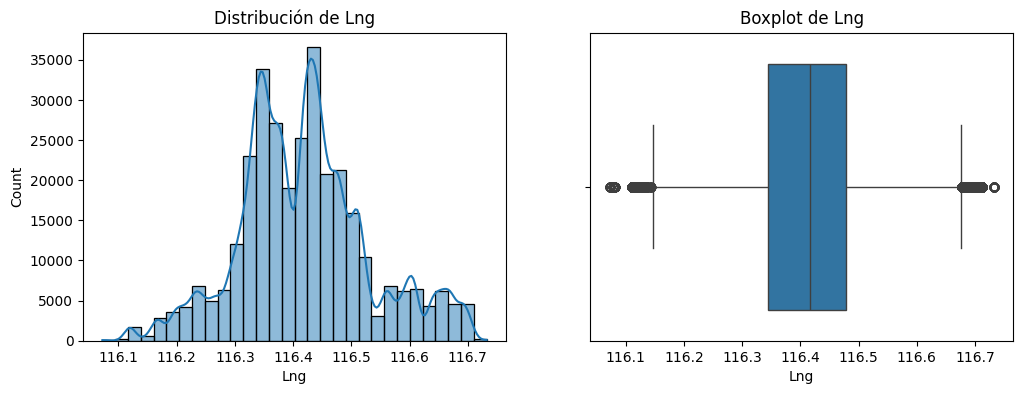

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable Lat tiene un p-valor de normalidad de 2.3902923990098314e-87


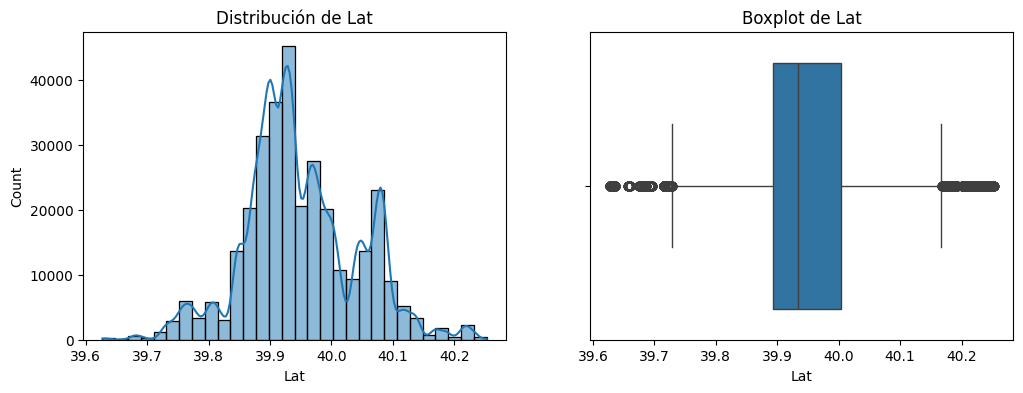

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 160849.
  res = hypotest_fun_out(*samples, **kwds)


Variable DOM tiene un p-valor de normalidad de 4.089416746639709e-166


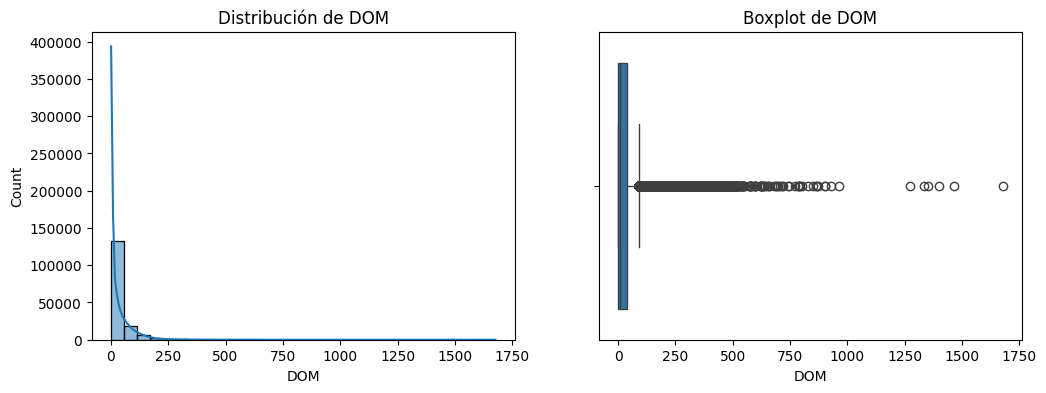

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable followers tiene un p-valor de normalidad de 2.2728400525777825e-190


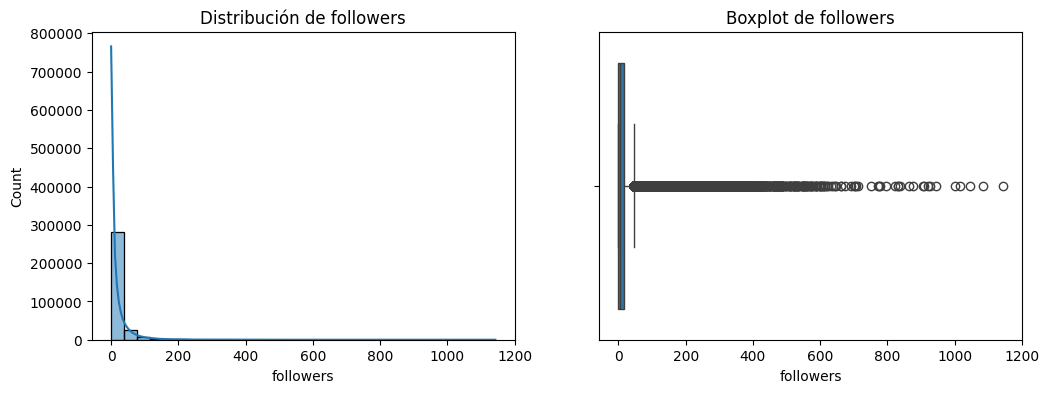

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable totalPrice tiene un p-valor de normalidad de 5.611336767786208e-163


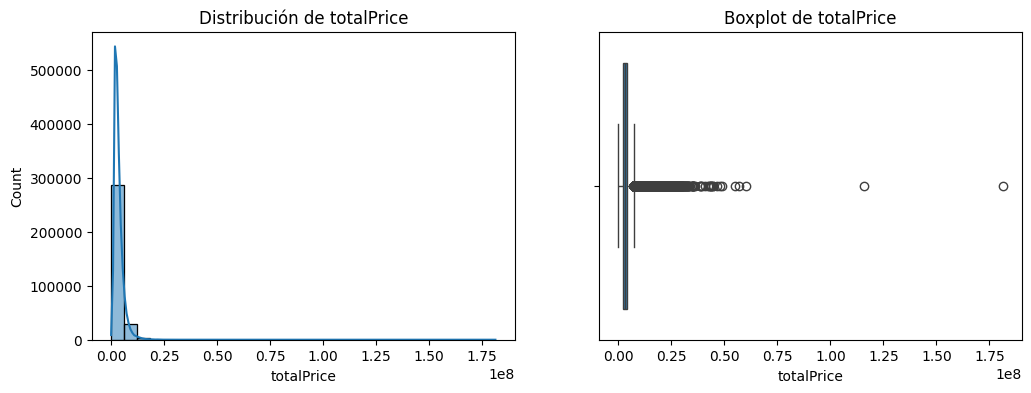

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable price tiene un p-valor de normalidad de 1.0261788978668301e-132


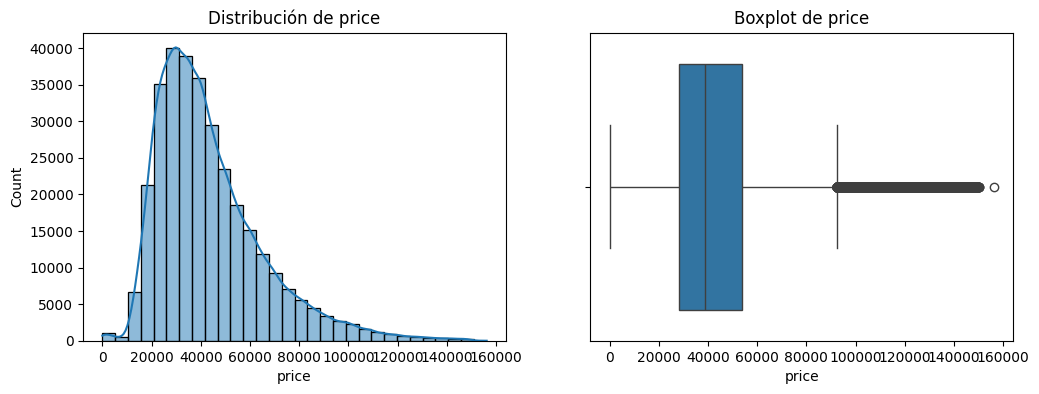

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable square tiene un p-valor de normalidad de 3.186150433071558e-146


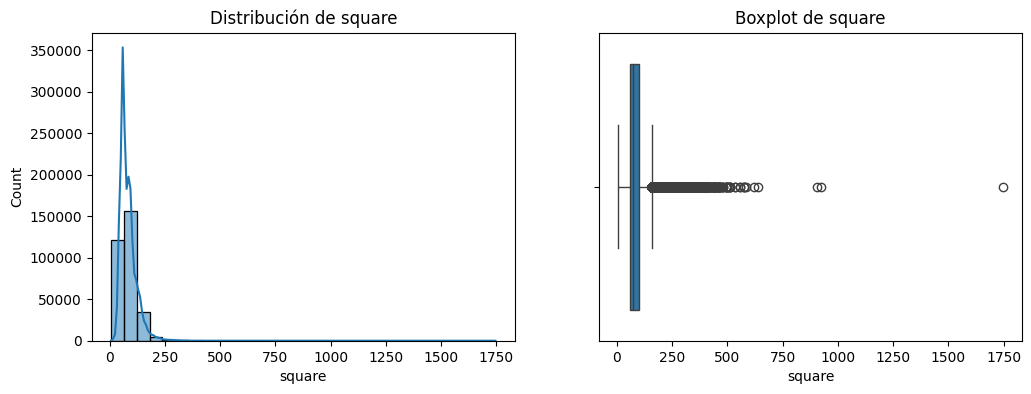

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable livingRoom tiene un p-valor de normalidad de 5.889656140175382e-152


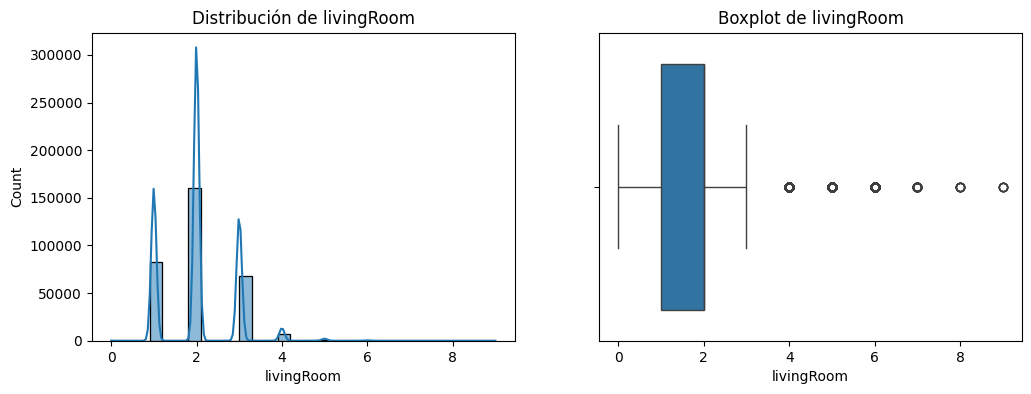

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable drawingRoom tiene un p-valor de normalidad de 3.9379968141391195e-172


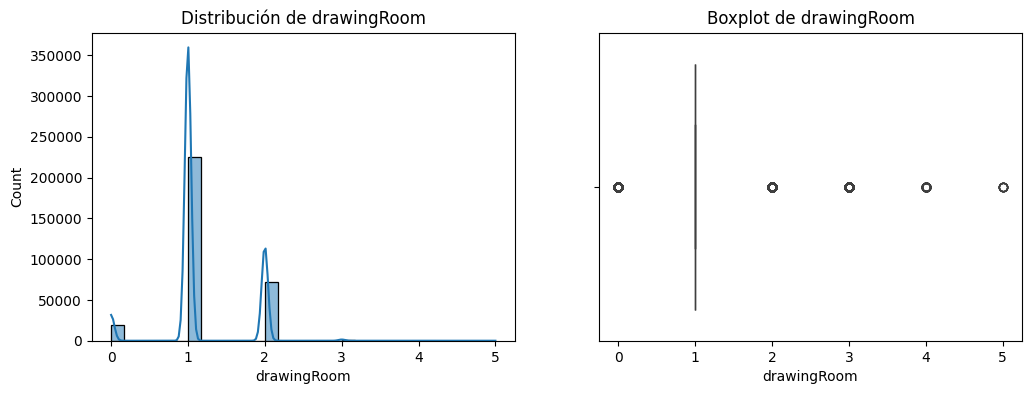

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable kitchen tiene un p-valor de normalidad de 4.1008146292059993e-212


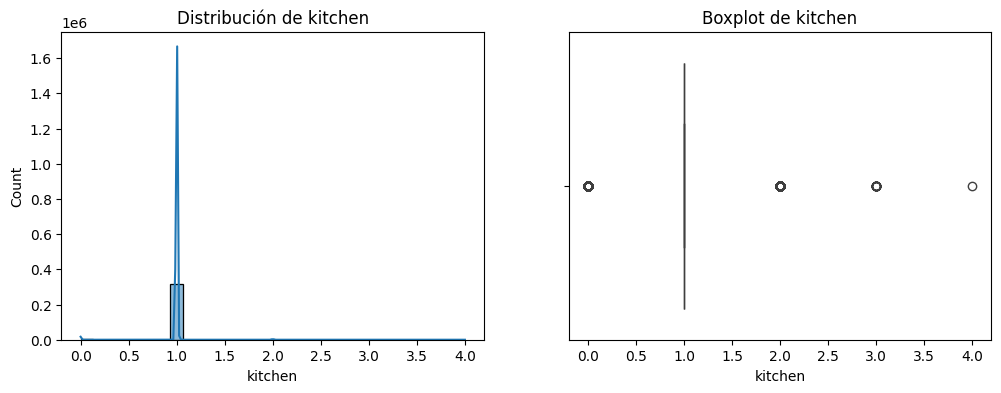

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable bathRoom tiene un p-valor de normalidad de 1.9851258731099373e-190


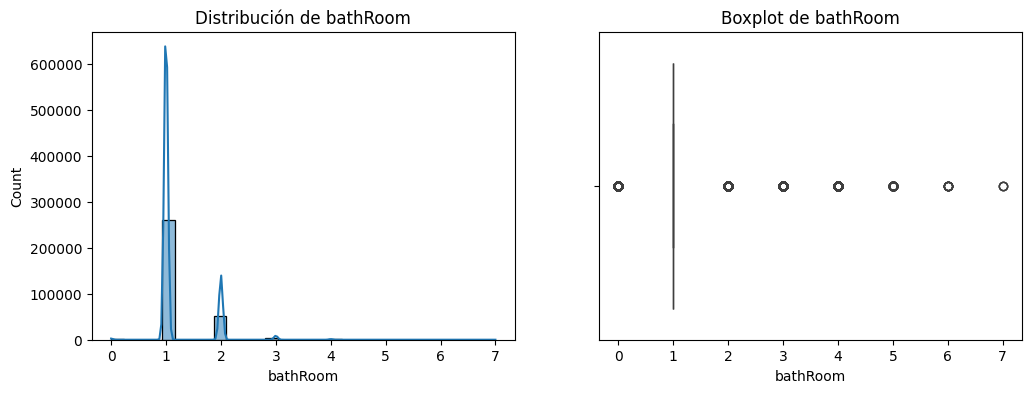

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 299536.
  res = hypotest_fun_out(*samples, **kwds)


Variable constructionTime tiene un p-valor de normalidad de 1.1301535867892136e-117


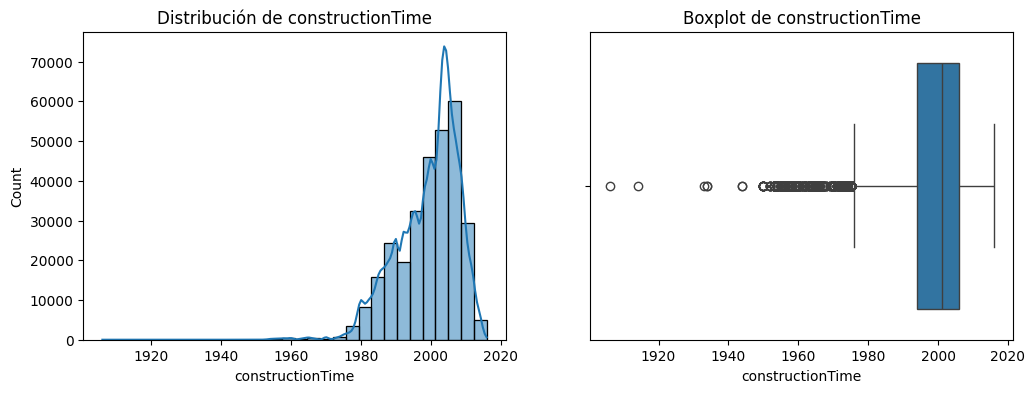

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318819.
  res = hypotest_fun_out(*samples, **kwds)


Variable ladderRatio tiene un p-valor de normalidad de 1.2437544885803837e-215


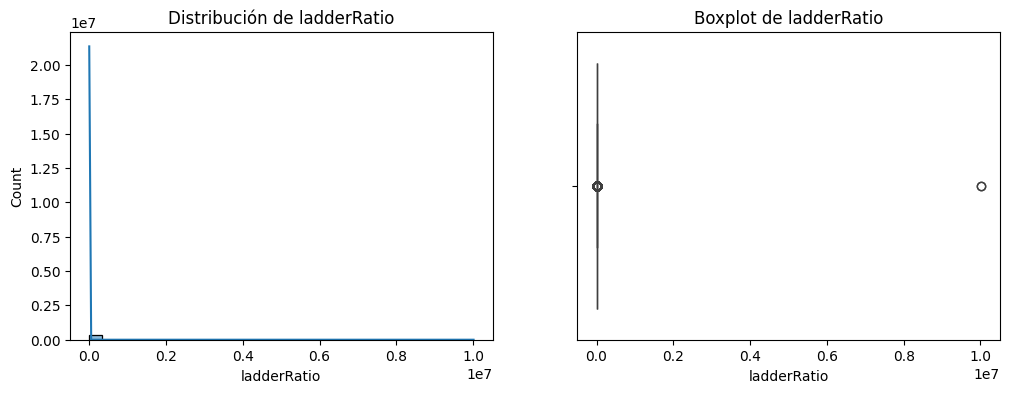

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318356.
  res = hypotest_fun_out(*samples, **kwds)


Variable communityAverage tiene un p-valor de normalidad de 4.72948326491239e-125


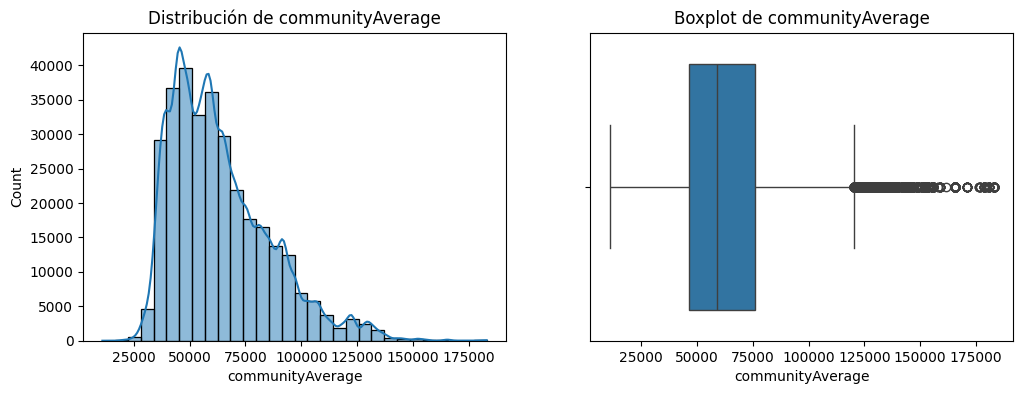

In [133]:
def primer_paso_outliers(df, lista_columnas: list[str]):
  '''
  Debe hacerse para columnas numericas
  '''
  for col in lista_columnas:
    # Chequeo de normalidad -> ya que es muy comun en outliers para despues transformar o no los datos
    print(f'Variable {col} tiene un p-valor de normalidad de {stats.jarque_bera(df[col].dropna()).pvalue}')

    # Visualizamos esa variable
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()
primer_paso_outliers(df, lista_cols)

In [134]:
def outliers_IQR(df, columna, severos=False):
    '''
    Debe hacerse solo para columnas numericas
    '''
    q_IQR = 3 if severos else 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - q_IQR * IQR
    limite_superior = Q3 + q_IQR * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    mask_outliers = (df[columna] < limite_inferior) | (df[columna] > limite_superior)
    return outliers, mask_outliers

def detectar_outliers_IQR(df, lista_columnas: list[str], p_valor_threshold=0.05, severos=False, imputo=False):
    '''
    Debe hacerse solo para columnas numericas
    '''
    df_copia = df.copy()
    masks_orig = dict()
    masks_transf = dict()
    for col in lista_columnas:
        mask = df_copia[col].notna()
        # Probamos si la columna sigue una distribucion normal
        print(f'Columna: {col}')
        p_valor = stats.jarque_bera(df_copia.loc[mask,col]).pvalue          # si la muestra es muy grande, usar stats.normaltest()
        print(f'P-valor de la prueba de normalidad: {p_valor}. {"" if p_valor > p_valor_threshold else "No "}se puede asumir normalidad.')

        # Contamos los outliers en la distribucion original
        outliers_orig, mask_outliers_orig = outliers_IQR(df_copia, col, severos=severos)
        q_outliers_original = outliers_orig.shape[0]
        print(f'Numero de outliers IQR detectados en la distribucion original: {q_outliers_original}')

        if p_valor > p_valor_threshold:
            mask_outliers_transf = None
            # Imputo si corresponde
            if imputo:
                mediana = df_copia.loc[~mask_outliers_orig, col].median()
                df_copia.loc[mask_outliers_orig == True, col] = mediana

        # Si la columna no sigue una distribución normal, aplicamos una transformacion
        else:
            minimo = df_copia[col].min()
            if minimo > 0:
                metodo = 'boxcox'
                data_bc, lambda_bc = stats.boxcox(df_copia.loc[mask, col])
                df_copia.loc[mask, metodo + '_' + col] = data_bc
            else:
                metodo = 'yeojohnson'
                data_yeo, lambda_yeo = stats.yeojohnson(df_copia.loc[mask, col])
                df_copia.loc[mask, metodo + '_' + col] = data_yeo
            outliers_transf, mask_outliers_transf = outliers_IQR(df_copia, metodo + '_' + col, severos=severos)
            q_outliers_transf = outliers_transf.shape[0]
            print(f'Metodo de transformacion aplicado: {metodo}')
            print(f'Numero de outliers IQR detectados en la distribucion transformada: {q_outliers_transf}')

            # Imputo si corresponde
            if imputo:
                mediana = df_copia.loc[~mask_outliers_transf, col].median()
                df_copia.loc[mask_outliers_transf == True, col] = mediana
        masks_orig[col] = mask_outliers_orig
        masks_transf[col] = mask_outliers_transf
        print()
    df_copia = df_copia.loc[:,lista_columnas]
    return df_copia, masks_orig, masks_transf

print('Outliers comunes')
outliers_comunes = detectar_outliers_IQR(df, lista_cols, p_valor_threshold=0.05, severos=False, imputo=False)
print('Outliers severos')
outliers_severos = detectar_outliers_IQR(df, lista_cols, p_valor_threshold=0.05, severos=True, imputo=False)

Outliers comunes
Columna: Lng
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 8107
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: Lat
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 6799
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: DOM
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 14895
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: followers
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 31339
Metodo de transformacion ap

Vemos que las distribuciones de los valores no son nada fuera de lo esperado. Hay outliers en las variables de la distribucion transformada pero se deben a valores anomalos no errores.

Cuando buscamos valores severos en la distribucion transformada, que son valores que nos deberian preocupar, vemos que la mayoria no tiene, o tienen muy pocos, pero se corresponden con lo que vimos arriba en los graficos y anteriormente tambien con los .value_counts() de variables discretas (ya sea cuantitativas discretas o categoricas). Un ejemplo seria una propiedad con 12 living rooms, lo cual es un dato verdadero, coherente, pero muy poco usual.

Por eso, tomamos la decision que lo mejor va a ser para los outliers severos (que son practicamente todos en el extremos superior de la distribucion) en la distribucion transformada, reemplazarlos por el maximo valor no outlier (o sea el limite superior de la caja).

Para los casos de bathRoom y drawingRoom, que son variables discretas, como la frecuencia del valor 1 hizo que la caja del boxplot sea solo el valor 1, vamos a imputar reemplazamos los outliers superiores (ej: 7 baños) por un valor superior que mantenga el sentido comun (ej: 3 baños), con el objetivo de tampoco distorsionar y afectar la capacidad predictiva del modelo con valores discretos con un numero sumamente pequeño de muestras.

In [124]:
def outliers(df, column):

  print(column)

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  # Primer gráfico: histograma
  axs[0].hist(df[column], bins=30, edgecolor="black", alpha=0.7)
  axs[0].set_title('Histograma')
  axs[0].set_xlabel("Valor")
  axs[0].set_ylabel("Frecuencia")

  # Segundo gráfico: boxplot
  axs[1].boxplot(df[column].dropna())
  axs[1].set_title("Boxplot")
  axs[1].set_ylabel("Valor")

  plt.tight_layout()
  plt.show()

  q1 = np.nanpercentile(df[column], 25)
  q3 = np.nanpercentile(df[column], 75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  outliers = df[(df[column] < lower) | (df[column] > upper)]
  print("Outliers:")
  print(len(outliers),end="\n\n")
  return len(outliers)

In [125]:
def outliers_bc(df,column):

  print(column)

  x= df[column].dropna()
  jb = stats.jarque_bera(x)          # Test de normalidad (asimetría + curtosis)
  print('jarque bera', jb.pvalue)

  if jb.pvalue <= 0.05:
    # obtener minimo valor de la columna
    minimo = x.min()
    # Aplicar Box-Cox para transformar la columna
    if minimo <= 0: #esto debido a que boxcox trabaja solo con positivos
      data_bc,lambda_bc = boxcox(x.apply(lambda x: x-minimo+0.00001)) #desplazo la columna hasta ser positiva, sumo ese decimal ya que sino puede quedar en 0
    else:
      data_bc,lambda_bc = boxcox(x)
    print('transformado con boxcox. lambda:',lambda_bc)
    # unir x con data_bc manteniendo el indice de x
    data_bc = pd.DataFrame(data_bc, index=x.index)
    # agregar columna data_bc a mi df donde coinciden los indices
    df[f'{column}_boxcox'] = data_bc
    cantidad=outliers(df, f'{column}_boxcox')

  else:
    cantidad=outliers(df, column)
  return cantidad

Lng
jarque bera 0.0
transformado con boxcox. lambda: -96.88012987076434
Lng_boxcox


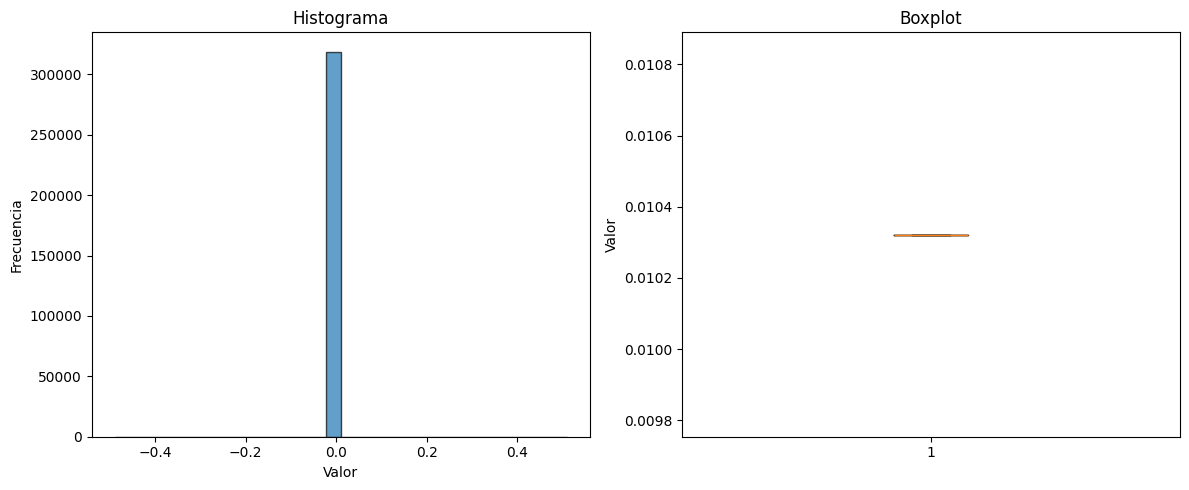

Outliers:
0

Lat
jarque bera 0.0
transformado con boxcox. lambda: -30.72714265604124
Lat_boxcox


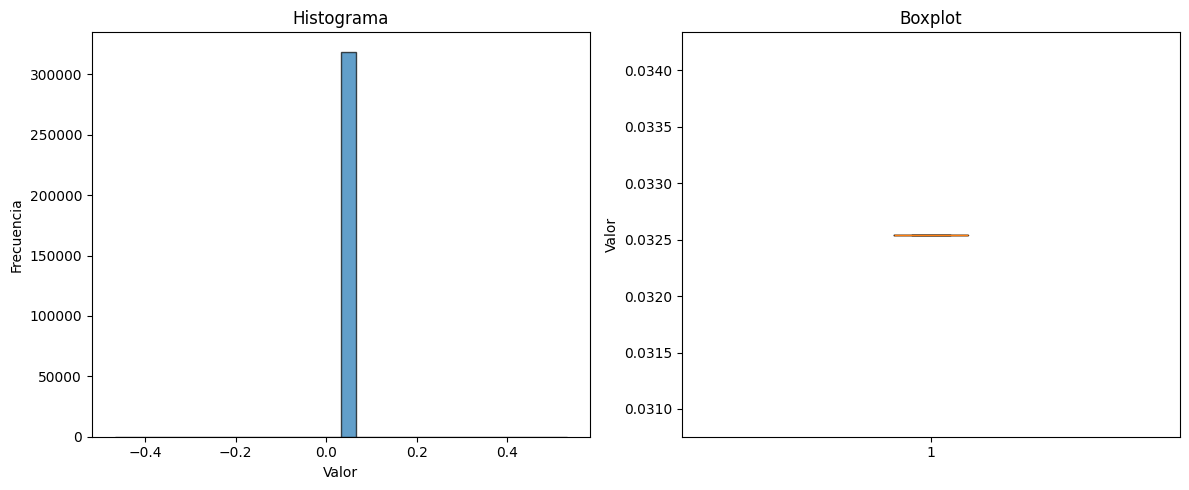

Outliers:
0

Cid
jarque bera 0.0
transformado con boxcox. lambda: -1357.0117146173257
Cid_boxcox


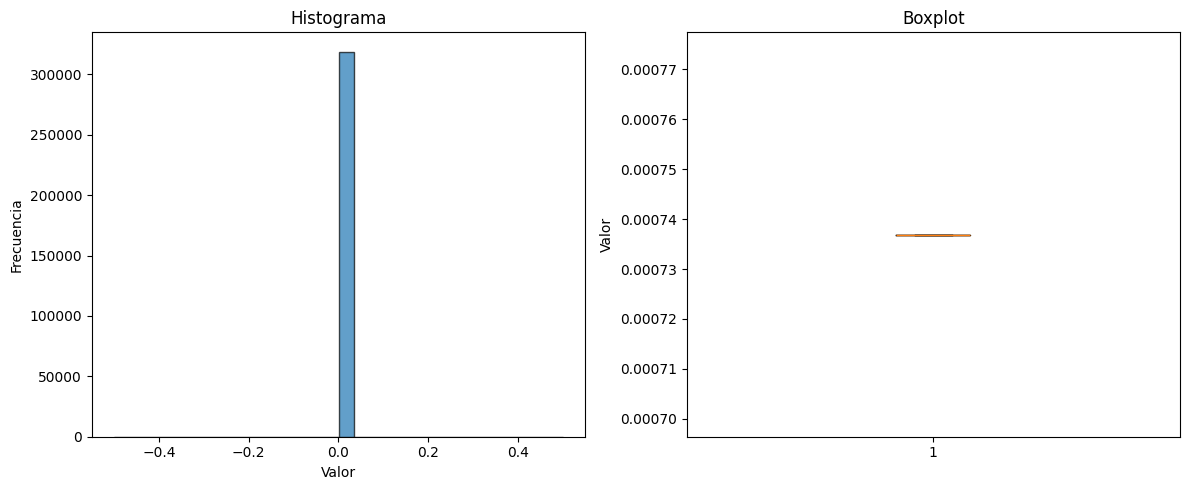

Outliers:
0

DOM
jarque bera 0.0
transformado con boxcox. lambda: -0.12821278473088676
DOM_boxcox


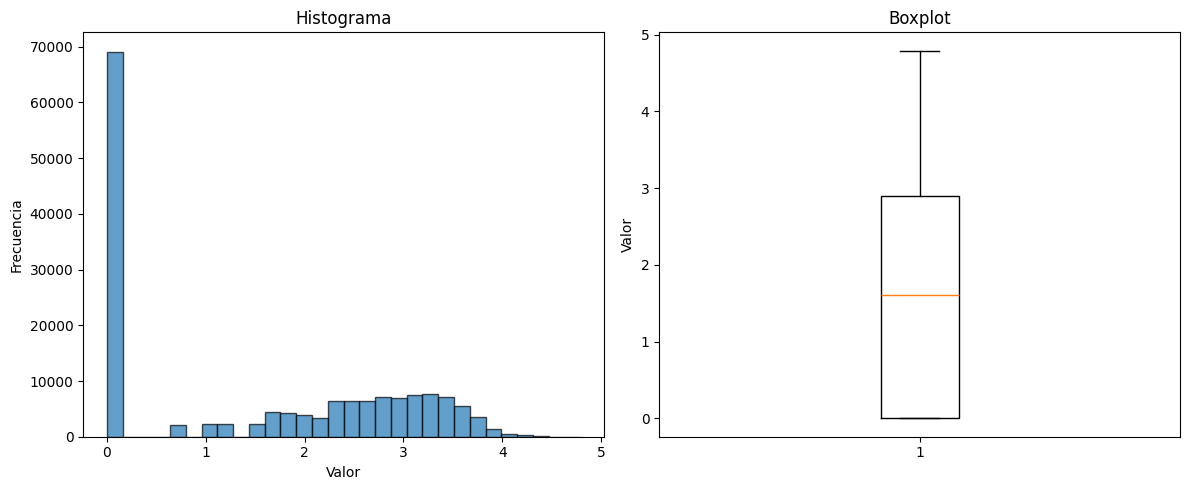

Outliers:
0

followers
jarque bera 0.0
transformado con boxcox. lambda: 0.149391321448533
followers_boxcox


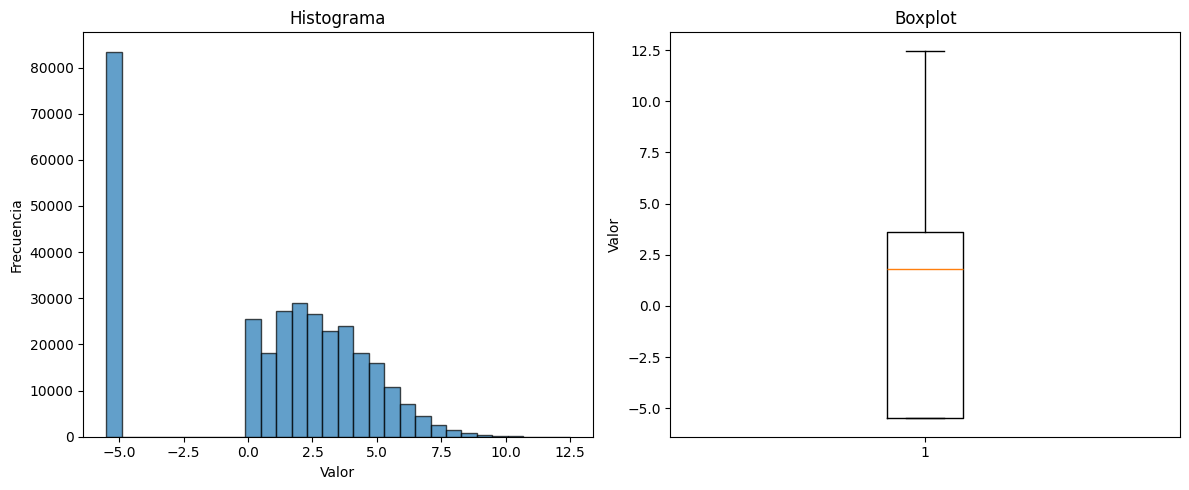

Outliers:
0

totalPrice
jarque bera 0.0
transformado con boxcox. lambda: 0.20548978448927166
totalPrice_boxcox


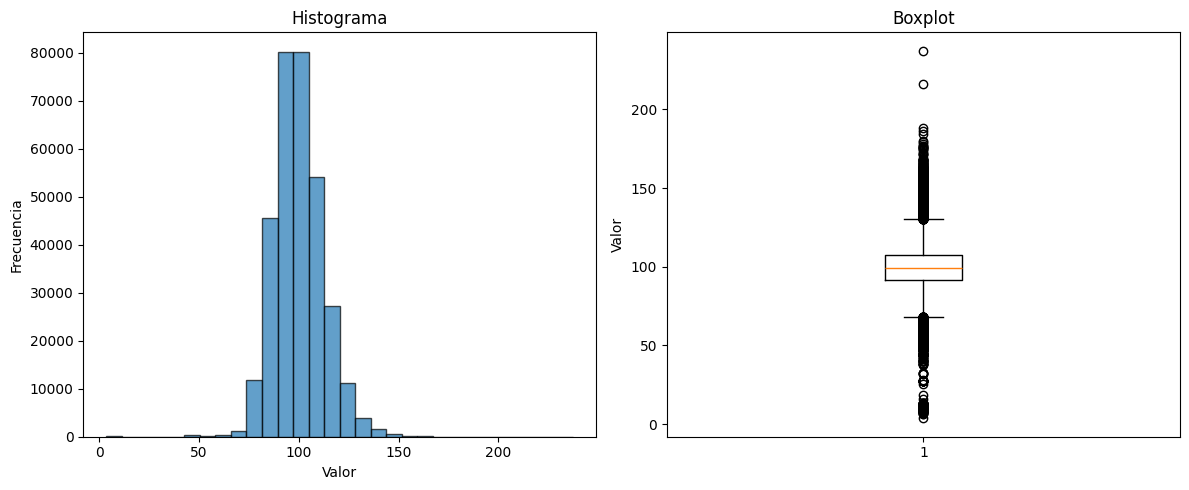

Outliers:
6082

price
jarque bera 0.0
transformado con boxcox. lambda: 0.32144332584298846
price_boxcox


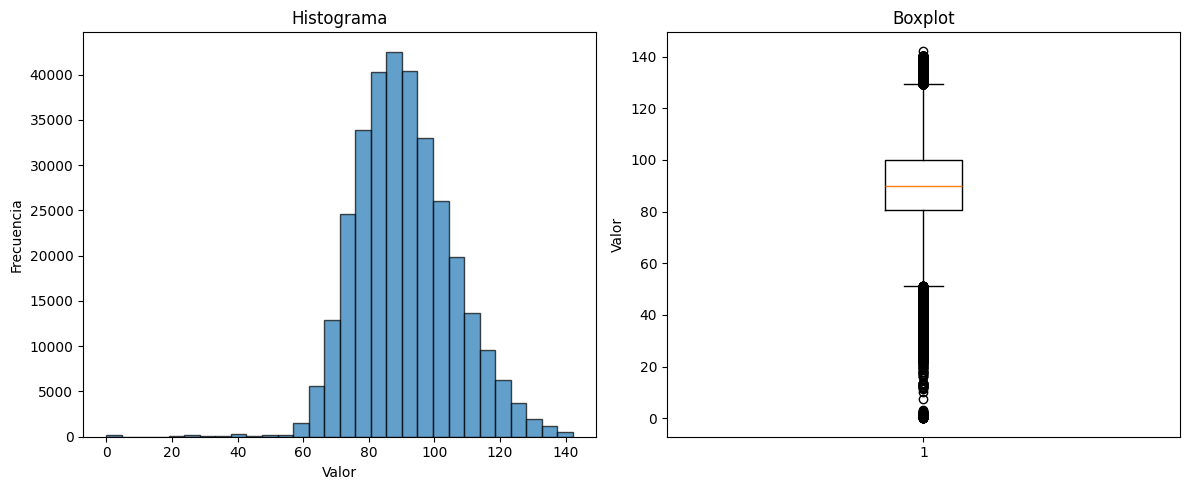

Outliers:
4116

square
jarque bera 0.0
transformado con boxcox. lambda: -0.18610300172203825
square_boxcox


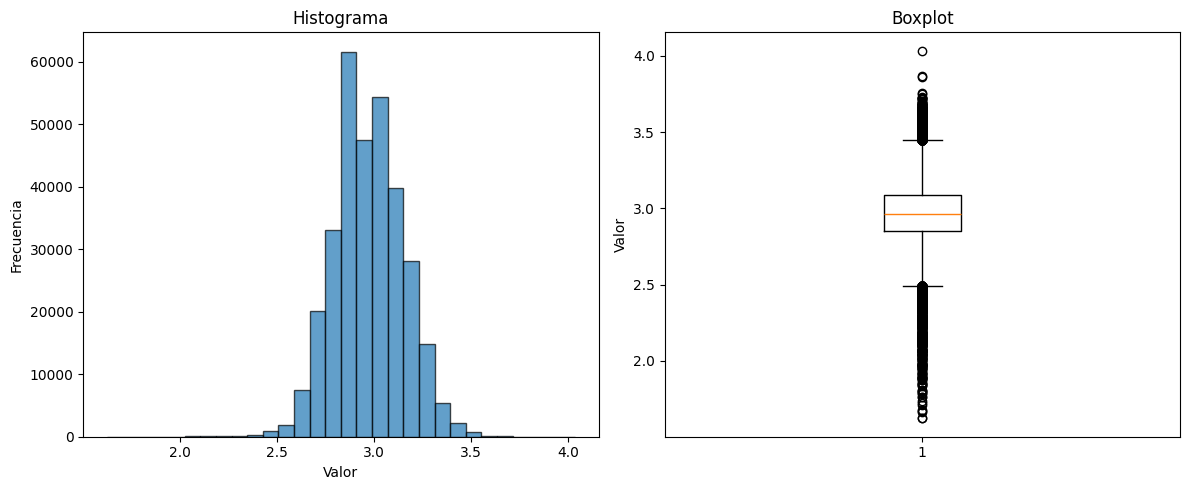

Outliers:
2833

livingRoom
jarque bera 0.0
transformado con boxcox. lambda: 0.4278194902119979
livingRoom_boxcox


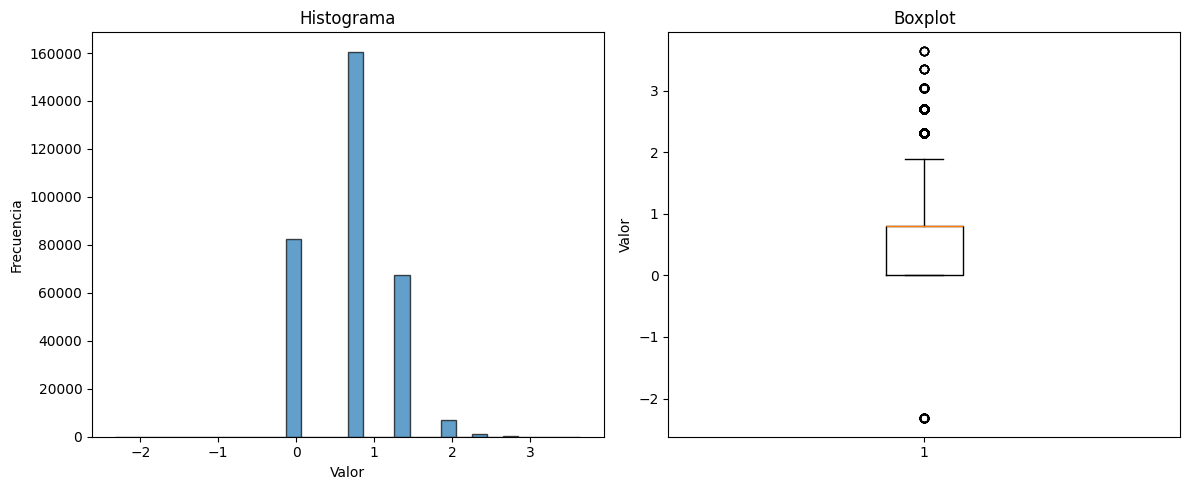

Outliers:
1412

drawingRoom
jarque bera 0.0
transformado con boxcox. lambda: 0.6540634648352491
drawingRoom_boxcox


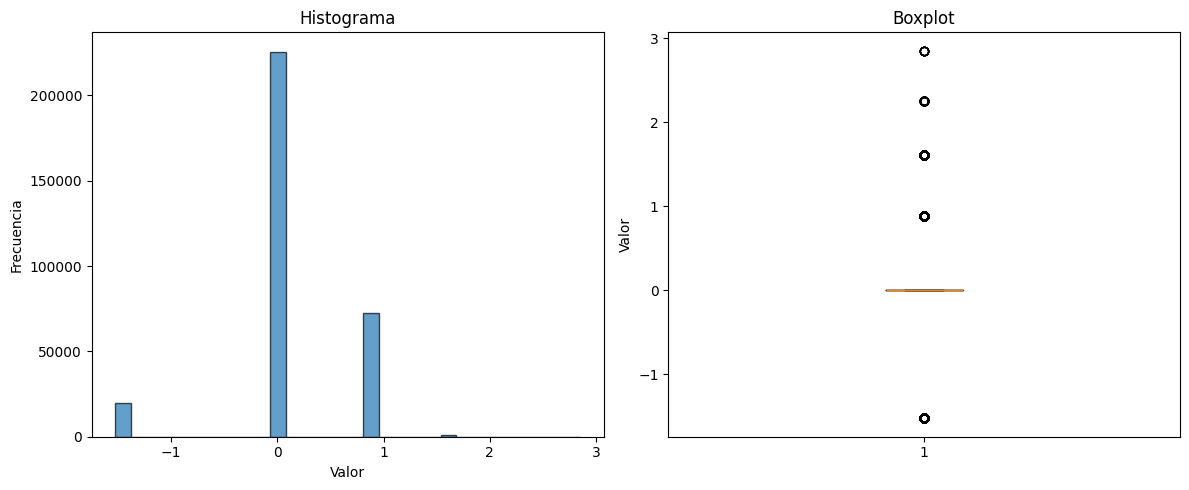

Outliers:
93160

kitchen
jarque bera 0.0
transformado con boxcox. lambda: 1.458007261638877
kitchen_boxcox


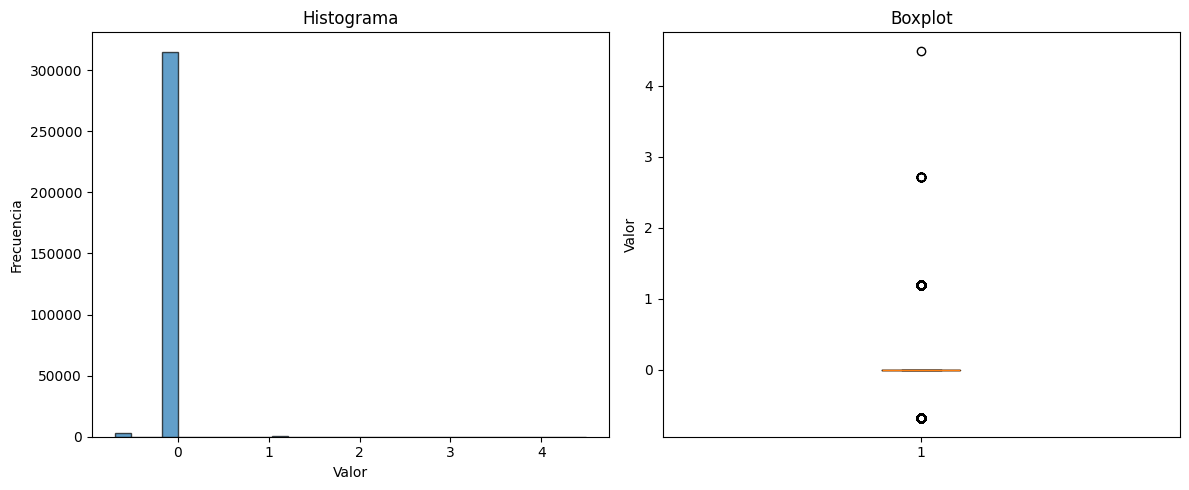

Outliers:
3531

bathRoom
jarque bera 0.0
transformado con boxcox. lambda: 0.432932505098867
bathRoom_boxcox


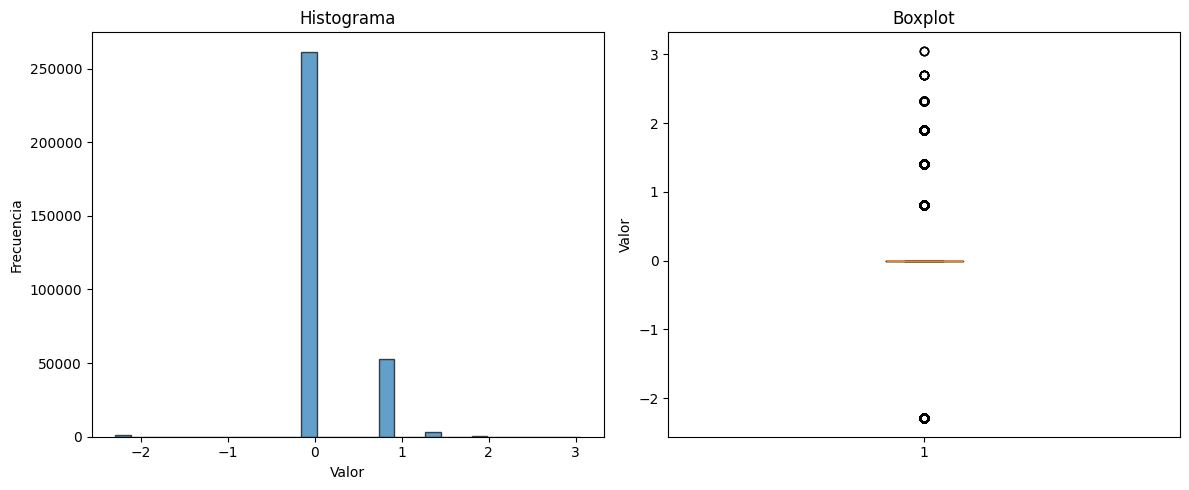

Outliers:
57331

buildingType
jarque bera 0.0
transformado con boxcox. lambda: 1.7551173074015707
buildingType_boxcox


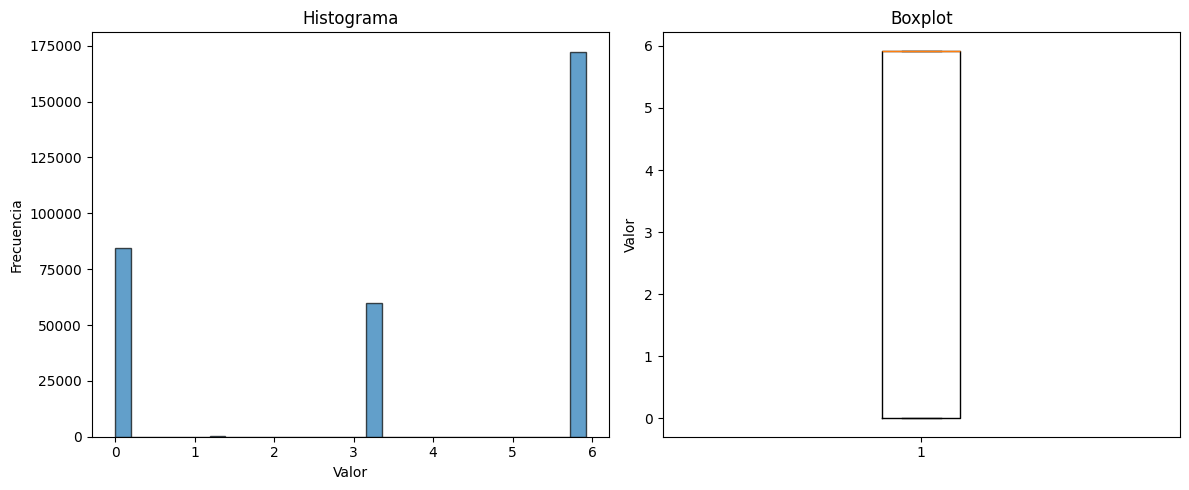

Outliers:
0

constructionTime
jarque bera 0.0
transformado con boxcox. lambda: 79.16053972430485
constructionTime_boxcox


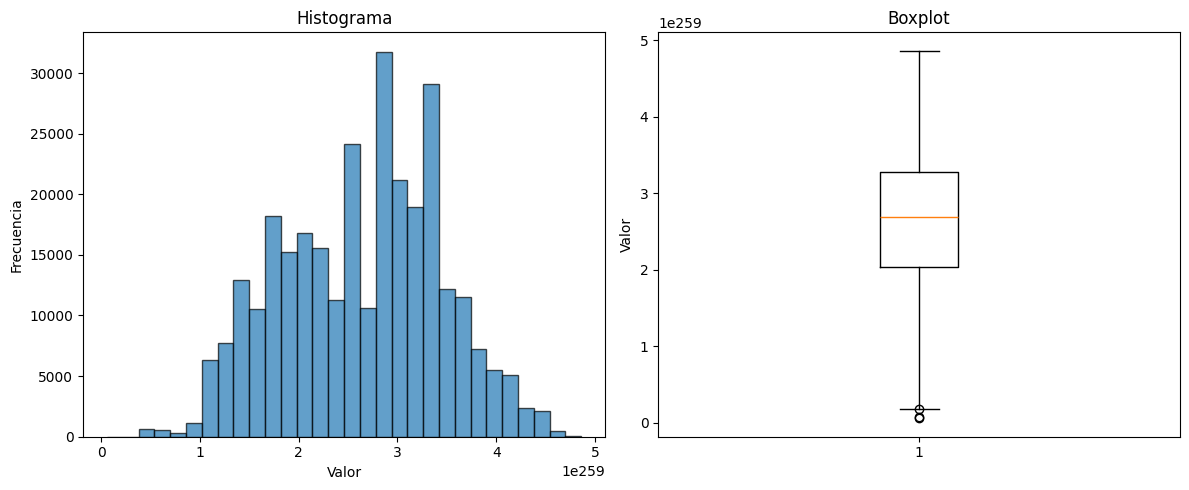

Outliers:
3

renovationCondition
jarque bera 0.0
transformado con boxcox. lambda: 0.7533194058186066
renovationCondition_boxcox


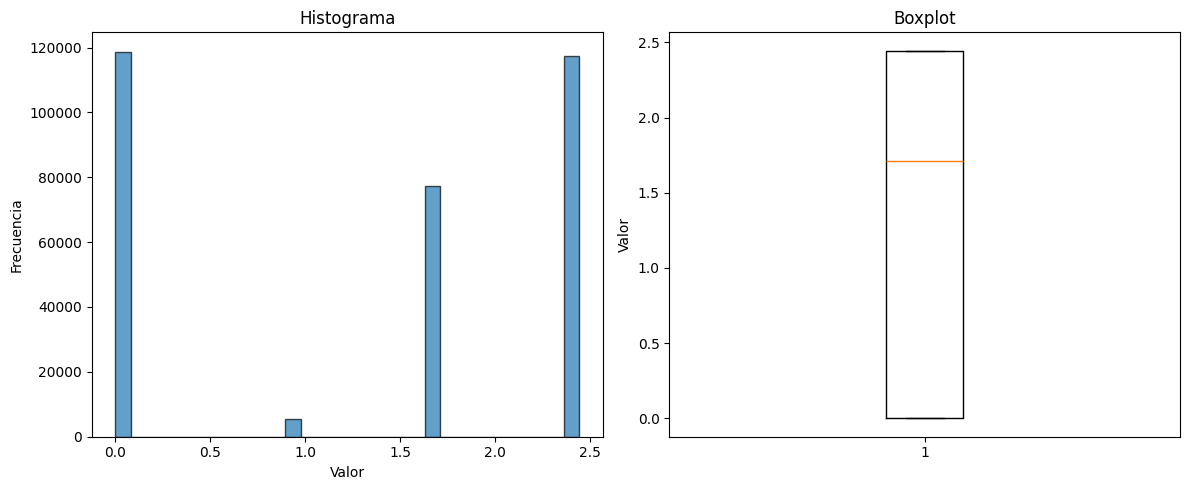

Outliers:
0

buildingStructure
jarque bera 0.0
transformado con boxcox. lambda: 1.3033355964070685
buildingStructure_boxcox


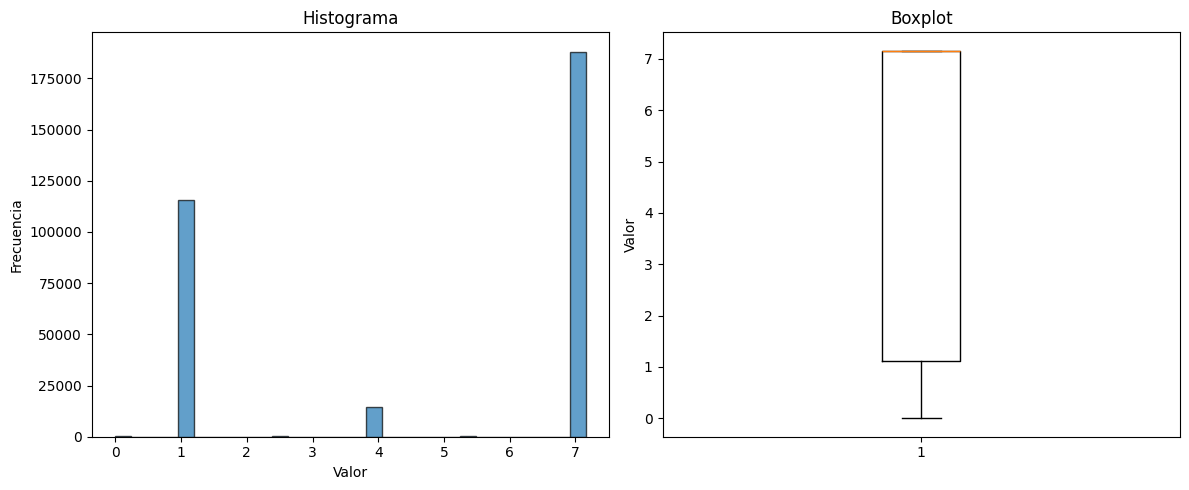

Outliers:
0

ladderRatio
jarque bera 0.0
transformado con boxcox. lambda: 0.0461568514201114
ladderRatio_boxcox


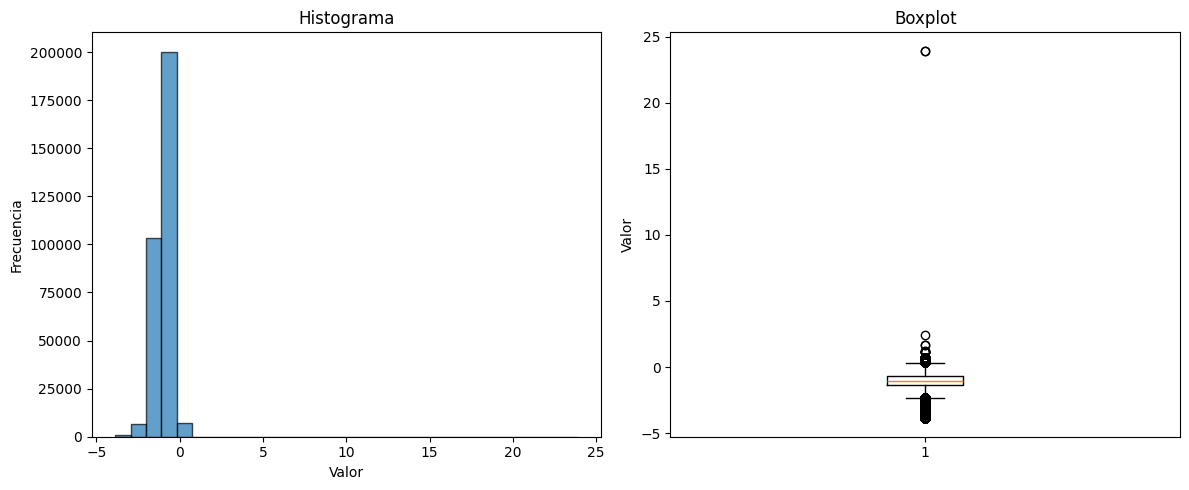

Outliers:
4492

elevator
jarque bera 0.0
transformado con boxcox. lambda: 0.08148530364807804
elevator_boxcox


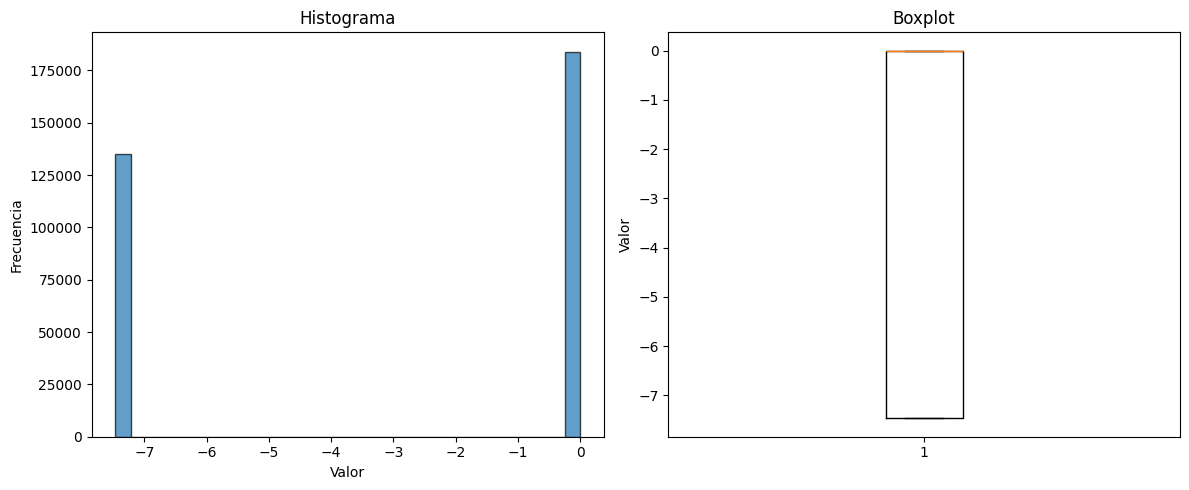

Outliers:
0

fiveYearsProperty
jarque bera 0.0
transformado con boxcox. lambda: 0.16015974260968138
fiveYearsProperty_boxcox


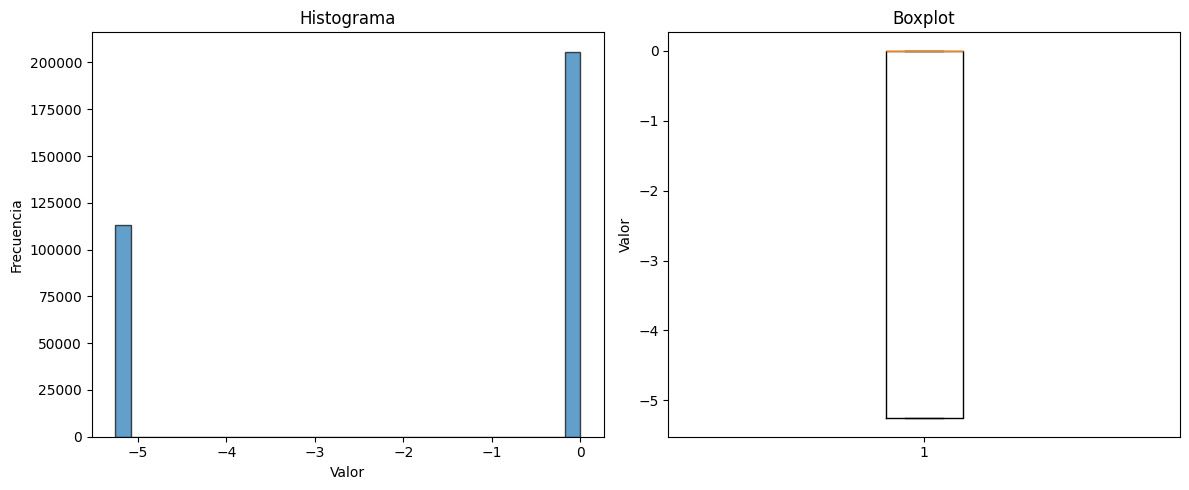

Outliers:
0

subway
jarque bera 0.0
transformado con boxcox. lambda: 0.10807992120589681
subway_boxcox


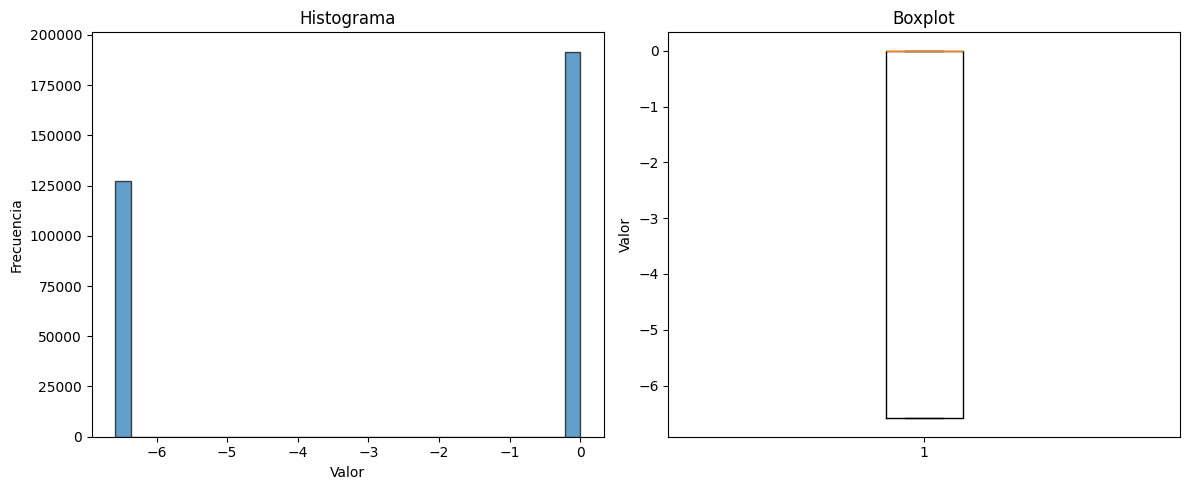

Outliers:
0

district
jarque bera 0.0
transformado con boxcox. lambda: 1.1104714027010776
district_boxcox


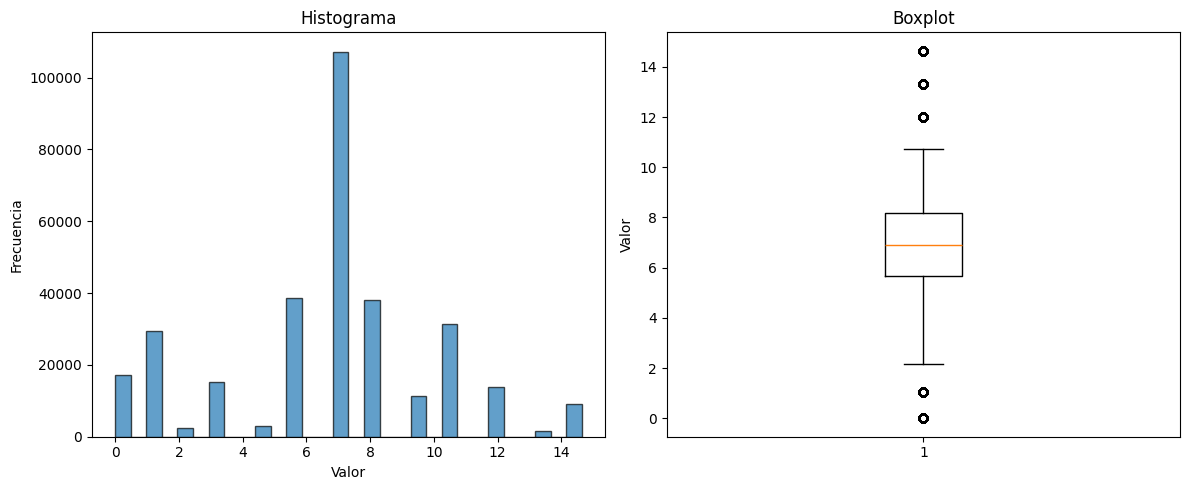

Outliers:
71278

communityAverage
jarque bera 0.0
transformado con boxcox. lambda: -0.3165039972273981
communityAverage_boxcox


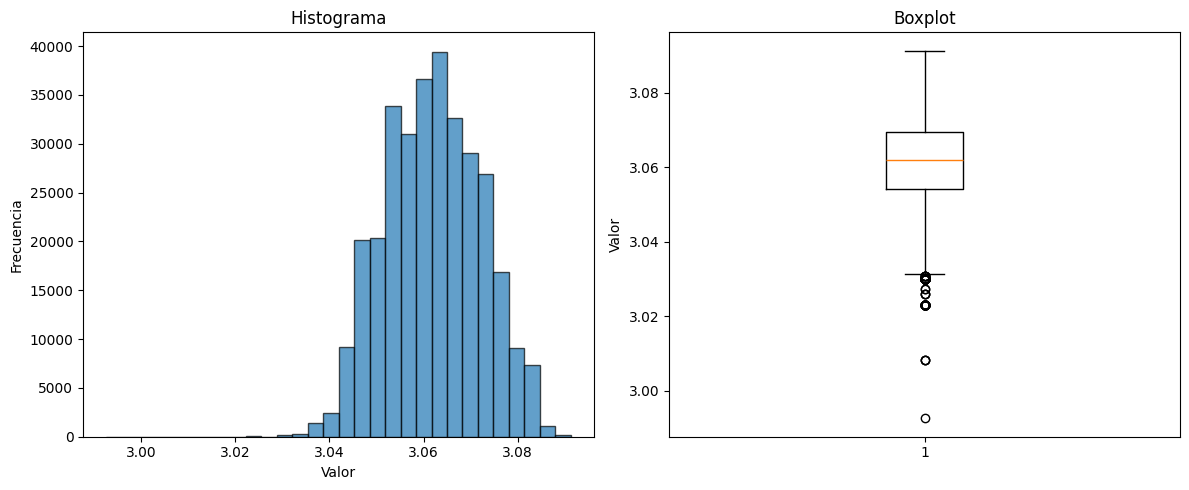

Outliers:
231



In [126]:
cantidad_outliers = []

for column in df.columns:
  if df[column].dtype == 'int64' or df[column].dtype=='float64':
    cantidad=outliers_bc(df, column)
    cantidad_outliers.append(cantidad)